In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from constants import CLASSES
from pathlib import Path
from utils import train_net

In [2]:
# for colab
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/deadskull7/fer2013/download" -O fer2013.zip
!python unpack_data.py

--2020-04-11 05:20:41--  https://www.kaggle.com/deadskull7/fer2013/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-data-sets/28577/36420/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586841641&Signature=f%2F%2FKZU9LNrtxtZRWkyn5qhnBB5KsFw%2BPQ7fQBwPBy9XTKqlQCpiqYzt1EqIhPZha13ywkFuFFGv0qmhufb2PjI99TcQH%2B8rsbak%2FcYgxesk1j5DpgzfPhqKrh4op5GObtNUXcr0nF0714QncorhAorZhbq7LswtKJ52xP1XoJnDljkLlRMZ0E1p49iYXuZwHJdnjL4yYoHlmjfPWzpAqOP8bHo4WAa0A1ko4g8d17Zd8Ej0YoiU72kW4fVVgEP2318URZxCCf5CW4hIsRyACgxk7Ik9ZGYaJz%2BVyLnMP2FgPR2ieWXlTUmJlzugdcLN1LOWoh5dGT%2Fh0%2B930YBY56w%3D%3D&response-content-disposition=attachment%3B+filename%3Dfer2013.zip [following]
--2020-04-11 05:20:41--  https://storage.googleapis.com/kaggle-data-sets/28577/36420/bundle/archive.zip?GoogleAcc

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

transform_augment = transforms.Compose(
    [
     transforms.Grayscale(),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.2),
     transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [0]:
trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform_augment)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

In [0]:
valset = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [0]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 18, 3)
        self.bn2 = nn.BatchNorm2d(18)
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(18, 36, 3)
        self.bn3 = nn.BatchNorm2d(36)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(36 * 10 * 10, 100)
        self.fc2 = nn.Linear(100, 7)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = x.view(-1, 36 * 10 * 10)
        x = self.dropout(x)
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [0]:
net = CustomNet()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=0.001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-4, max_lr=1e-3, cycle_momentum=False, step_size_up=449)

[1,   120] train_loss: 1.826, val_loss: 1.648, val_acc: 0.369
[1,   240] train_loss: 1.736, val_loss: 1.583, val_acc: 0.393
[1,   360] train_loss: 1.696, val_loss: 1.538, val_acc: 0.424
[2,   120] train_loss: 1.633, val_loss: 1.491, val_acc: 0.436
[2,   240] train_loss: 1.598, val_loss: 1.478, val_acc: 0.437
[2,   360] train_loss: 1.573, val_loss: 1.451, val_acc: 0.449
[3,   120] train_loss: 1.569, val_loss: 1.410, val_acc: 0.461
[3,   240] train_loss: 1.540, val_loss: 1.398, val_acc: 0.468
[3,   360] train_loss: 1.536, val_loss: 1.395, val_acc: 0.469
[4,   120] train_loss: 1.529, val_loss: 1.389, val_acc: 0.468
[4,   240] train_loss: 1.508, val_loss: 1.371, val_acc: 0.478
[4,   360] train_loss: 1.508, val_loss: 1.373, val_acc: 0.484
[5,   120] train_loss: 1.478, val_loss: 1.356, val_acc: 0.485
[5,   240] train_loss: 1.492, val_loss: 1.360, val_acc: 0.481
[5,   360] train_loss: 1.497, val_loss: 1.346, val_acc: 0.485
[6,   120] train_loss: 1.454, val_loss: 1.328, val_acc: 0.492
[6,   24

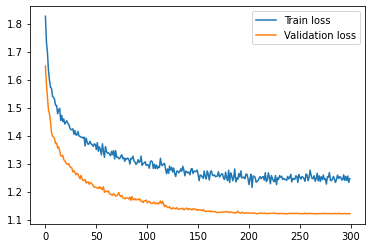

In [9]:
train_net(net, trainloader, valloader, criterion, optimizer, device, 
          num_epochs=100, lr_scheduler=scheduler, eval_period=120)

In [0]:
Path('weights').mkdir(exist_ok=True)
PATH = 'weights/custom_net.pth'
torch.save(net.state_dict(), PATH)

### Evaluating

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
net = CustomNet()
net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()

CustomNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3600, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=7, bias=True)
)

In [0]:
testset = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
testloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 57 %


In [35]:
class_correct = [0. for i in range(len(CLASSES))]
class_total = [0. for i in range(len(CLASSES))]
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).reshape(1, -1)
        for i in range(c.size()[1]):
            label = labels[i].item()
            class_correct[label] += c[0, i].item()
            class_total[label] += 1


for i in range(len(CLASSES)):
    print('Accuracy of %5s : %2d %%' % (
        CLASSES[i], 100 * class_correct[i] / class_total[i]))

Accuracy of angry : 42 %
Accuracy of disgust : 25 %
Accuracy of  fear : 23 %
Accuracy of happy : 83 %
Accuracy of   sad : 50 %
Accuracy of surprise : 75 %
Accuracy of neutral : 57 %
